In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ts_modelling.data_producer import DataProducer
from ts_modelling.simple_experiment import SimpleExp
from argparse import Namespace
import yaml
%matplotlib inline

with open('args.yaml', 'r') as file:
    config = yaml.safe_load(file)
args = Namespace(**config)
exp = SimpleExp(args)

length = 5000

Use CPU


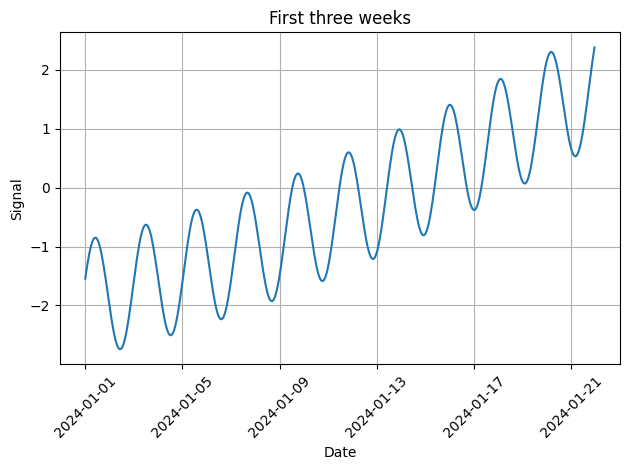

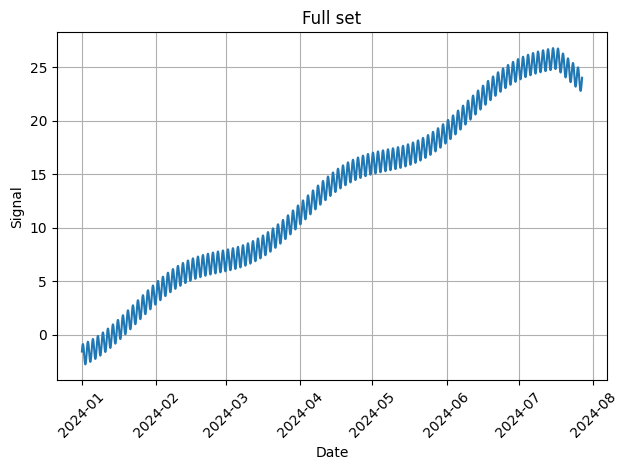

In [2]:
dp = DataProducer(length=length, n_vars=1, path=args.root_path, noise_amp=0)
dp.add_sine(freq_amp=[(3/length,1), (100/length, 1)])
dp.add_trend(nbr_trends=2, slope=50/length)
dp.plot_data()

In [3]:
dp.generate_csv()

In [4]:
exp.train()

ValueError: list.remove(x): x not in list

In [4]:
import os
os.makedirs(args.root_path, exist_ok=True)
data_path = os.path.join(args.root_path, 'custom')
dp.df.to_csv(data_path, index=False)